# AdventureWorks Försäljningsanalys

I denna analys undersöker vi AdventureWorks-databasen för att besvara affärsfrågor som ex:
- Produktkategorier och deras försäljnig 
- Försäljningstrender
- Regional försäljning

Vi använder SQL för att hämta data och Python för visualisering och analys.

In [ ]:
import pandas as pd 
from sqlalchemy import create_engine, text
from urllib.parse import quote_plus
import matplotlib.pyplot as plt

user = "sa"
password = quote_plus("WorldWide85")
server = 'localhost,1433'
database = 'AdventureWorks2019'
driver = quote_plus("ODBC Driver 18 for SQL server")


connection_string = (
    f"mssql+pyodbc://{user}:{password}@{server}/{database}"
    f"?driver={driver}&Encrypt=yes&TrustServerCertificate=yes"
)

engine = create_engine(connection_string)


try:
    with engine.connect():
        print("Anslutning till SQL Server lyckades")
except Exception as e:
    print("Kunde inte ansluta", e)

In [ ]:
def query_df(sql: str):
    with engine.connect() as conn:
        return pd.read_sql(text(sql), conn)

## Visualisering 1: Antal produkter per kategori
Hur många produkter finns i varje kategori?

Tabeller som använts:
Production.ProductCategory
Production.ProductSubcategory
Production.Product

Planering:
JOINA tabellerna
Räkna DISTINCT produkter per kategori
Skapa vertikalt stapeldiagram
Analsera resultatet

,CategoryName,ProductCount
0,Components,134
1,Bikes,97
2,Clothing,35
3,Accessories,29


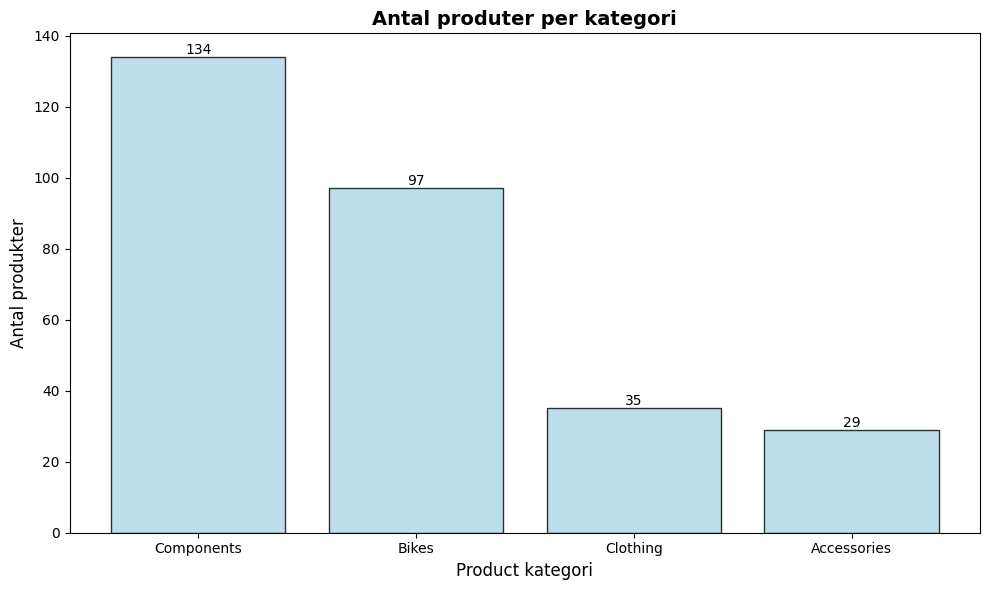

In [12]:
query_vis1 = """
SELECT
    pc.Name AS CategoryName,
    COUNT(DISTINCT p.ProductID) AS ProductCount
  
FROM Production.ProductCategory pc
INNER JOIN Production.ProductSubcategory psc ON pc.ProductCategoryID = psc.ProductCategoryID
INNER JOIN Production.Product p ON psc.ProductSubcategoryID = p.ProductSubcategoryID
GROUP BY pc.Name
ORDER BY ProductCount DESC

"""

df_vis1 = query_df(query_vis1)
display(df_vis1)

fig, ax = plt.subplots(figsize=(10,6))

bars = ax.bar(df_vis1['CategoryName'], df_vis1['ProductCount'], color='lightblue', edgecolor='black', alpha=0.8)

for bar in bars:
    height = bar.get_height()
    ax.text( 
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{int(height)}',
        ha='center',
        va='bottom'
    )
   


ax.set_xlabel('Product kategori',fontsize=12)
ax.set_ylabel('Antal produkter',fontsize=12)
ax.set_title('Antal produter per kategori', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()




### Insikter - Antal produkter per kategori
Components är största kategorin med 134 produkter.
Accessoarer är minst med 29 produkter.

Detta indikerar på att företaget är starkt fokuserat på komponenter och reservdelar.
Och att accessoarer kan vara ett utvecklings område.

# Visualisering 2: Total försäljning per produktkategori

Vilka produktkategorier genererar mest intäkter?

Vi hämtar data från tabellerna SalesOrderDetail, Product, ProductSubcategory och ProductCategory. Vi summerar försäljningen per kategori och sorterar från högst till lägst

,CategoryName,TotalSales
0,Bikes,9.465117e+07
1,Components,1.180259e+07
2,Clothing,2.120543e+06
3,Accessories,1.272073e+06


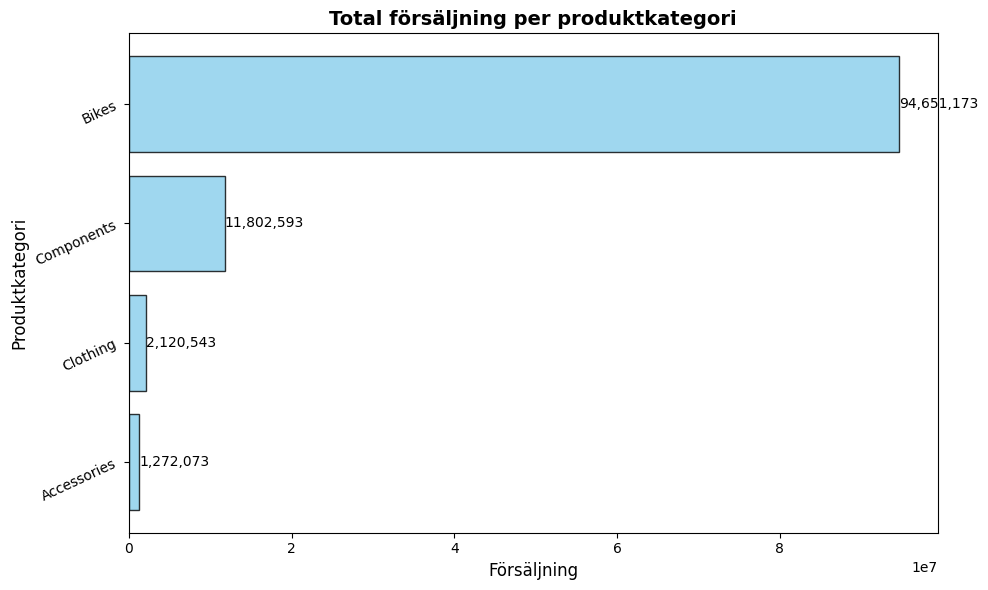

In [27]:
query_vis2 = """ 
SELECT
    pc.Name AS CategoryName,
    SUM(sod.LineTotal) AS TotalSales
FROM 
    Sales.SalesOrderDetail sod
INNER JOIN Production.Product p ON sod.ProductID = p.ProductID
INNER JOIN Production.ProductSubcategory psc ON p.ProductSubcategoryID = psc.ProductSubcategoryID
INNER JOIN Production.ProductCategory pc ON psc.ProductCategoryID = pc.ProductCategoryID

GROUP BY 
    pc.Name
ORDER BY
    TotalSales DESC;
"""

df_vis2 = query_df(query_vis2)
display(df_vis2)


fig, ax = plt.subplots(figsize=(10,6))
bars = ax.barh(df_vis2['CategoryName'], df_vis2['TotalSales'], color='skyblue', edgecolor='black', alpha=0.8)
ax.set_title('Total försäljning per produktkategori',fontsize=14, fontweight='bold')
ax.set_xlabel('Försäljning', fontsize=12)
ax.set_ylabel('Produktkategori', fontsize=12)
ax.invert_yaxis()

for bar in bars:
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2,f'{width:,.0f}', va='center')

plt.yticks(rotation=25) 
plt.tight_layout()
plt.show()


### Insikter - Totalförsäljning per produktkategori

Stapeldiagrammet visar tydligt vilken produktkategori som genererar mest och minst försäljning.  

Kategorin **Bikes** har högst total försäljning med 94,651,173 sålda.  
Kategorin **Accessories** har lägst total försäljning med 1,272,072 sålda.  

Detta hjälper oss att förstå vilka produktområden som bidrar mest till intäkterna.
